In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.preprocessing import LabelEncoder,Imputer

In [30]:
df = pd.read_csv('./data/responses.csv')

In [31]:
df.head()

,Timestamp,Email Address,Name,Neighbourhood,Rating,Brands,Flavor,Packaging,Source,Type,Frequency,Price,Quality,Occasion,New_flavors
0,2/6/2018 19:12:51,NaN,Neha Baranwal,Thane,10,"Mother Dairy, Amul","Chocolate, Butterscotch",Cone,"Supermarkets, Ice cream parlour/ restaurants",Unit,Once a week,7.0,10.0,5,5.0
1,2/6/2018 19:17:21,NaN,Arvind Narayanan,Chembur,8,"Dinshaw’s, Amul, Kwality Walls","Chocolate, Vanilla, Butterscotch, Pistachio",Cone,"Ice cream parlour/ restaurants, Minimart",Unit,Once a month,7.0,8.0,10,4.0
2,2/6/2018 21:01:58,2015bhavika.adnani@ves.ac.in,Bhavika,Thane,8,"Baskin-Robbins, Amul, Kwality Walls","Chocolate, Vanilla, Coffee",Cone,"Ice cream parlour/ restaurants, Ice cream cart...",Unit,Once a month,1.0,10.0,8,6.0
3,2/6/2018 21:02:15,2015mayank.agrawal@ves.ac.in,Mayank Agrawal,Chembur,9,"Baskin-Robbins, Amul, Creambell","Chocolate, Butterscotch",Cone,Ice cream parlour/ restaurants,Unit,Once a month,2.0,10.0,9,4.0
4,2/6/2018 21:09:39,2015bhuvanesh.goplani@ves.ac.in,Bhuvanesh Goplani,Chembur,4,"Baskin-Robbins, Home made","Vanilla, Strawberry, Butterscotch",Tub,Ice cream parlour/ restaurants,Unit,Once a month,3.0,10.0,6,5.0


## Preprocessing

### Removing redundant columns

In [32]:
df.columns

Index(['Timestamp', 'Email Address', 'Name', 'Neighbourhood', 'Rating',
       'Brands', 'Flavor', 'Packaging', 'Source', 'Type', 'Frequency', 'Price',
       'Quality', 'Occasion', 'New_flavors'],
      dtype='object')

In [33]:
df = df.drop(['Timestamp', 'Email Address', 'Name', 'Type'], 1)

### Dealing with null values

In [34]:
df.isnull().sum()

Neighbourhood    6
Rating           0
Brands           1
Flavor           0
Packaging        0
Source           1
Frequency        1
Price            1
Quality          2
Occasion         0
New_flavors      1
dtype: int64

In [35]:
def convStringToCat(df, column):
    nullCols = df[column].isnull()
    df[column][nullCols] = 'NaN'
    df[column] = df[column].str.lower().str.strip()
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].values)
    df[column][nullCols] = np.nan

In [36]:
convStringToCat(df, 'Neighbourhood')
convStringToCat(df, 'Frequency')
convStringToCat(df, 'Packaging')

C:\Users\Ajay\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ajay\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [37]:
def removeMissingVals(col):
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    df[col]=imp.fit_transform(df[[col]])

removeMissingVals("Neighbourhood")
removeMissingVals("Price")
removeMissingVals("Quality")
removeMissingVals("New_flavors")
removeMissingVals("Frequency")

df[['Neighbourhood','Price','Quality', 'New_flavors', 'Frequency']].isnull().sum()

Neighbourhood    0
Price            0
Quality          0
New_flavors      0
Frequency        0
dtype: int64

### Splitting multivalued attribues

In [38]:
def fetchOneHotColumns(df, column):
    type_columns = [type_.split(", ") if type(type_) != float else [] for type_ in df[column]]
    types = list(set(chain.from_iterable(type_columns)))
    typeDict = {}
    for type_ in types:
        typeDict[type_] = []
    for type_set in type_columns:
        for type_ in typeDict:
            if type_ in type_set:
                typeDict[type_].append(1)
            else:
                typeDict[type_].append(0)
    df_types = pd.DataFrame(typeDict)
    if 'any brand ' in df_types.columns:
        df_types = df_types.drop('any brand ', axis=1)
    return types, df_types

In [39]:
multivaluedCols = ['Brands', 'Flavor', 'Source']
multivaluedColDict = {}
for col in multivaluedCols:
    types, df_types = fetchOneHotColumns(df, col)
    multivaluedColDict[col] = types
    df = df.join(df_types).drop(col, axis=1)

In [40]:
df.isnull().sum()

Neighbourhood                     0
Rating                            0
Packaging                         0
Frequency                         0
Price                             0
Quality                           0
Occasion                          0
New_flavors                       0
Amul                              0
Baskin-Robbins                    0
Creambell                         0
Dinshaw’s                         0
Gelato Italiano                   0
Havmor                            0
Home made                         0
Kwality Walls                     0
Local Icecream shops              0
London Dairy                      0
Mother Dairy                      0
Naturals                          0
Vadilal                           0
patanjali icecreame               0
Butterscotch                      0
Chocolate                         0
Coffee                            0
Custard apple                     0
Mango                             0
Mint                        

### Label encoding and one hot encoding

## Visualization

### Location wise distribution of flavors and brands

### Area wise dominating factor

### Brand vs like-scale mapping

### Source vs Location

### Brand vs Flavor

### Rating vs (Price, Quality, Occasion and new flavors)



Text(0,0.5,'Price')

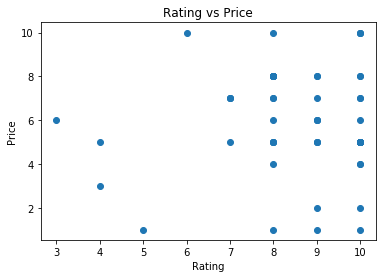

In [41]:
x=df.Rating.values
y=df.Price.values
plt.scatter(x,y)
plt.title("Rating vs Price")
plt.xlabel("Rating")
plt.ylabel("Price")

Text(0,0.5,'Quality')

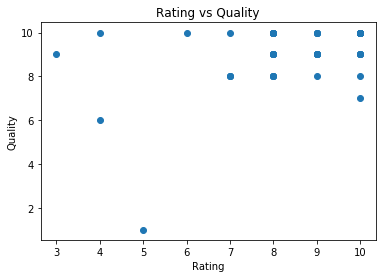

In [42]:
x=df.Rating.values
y=df.Quality.values
plt.scatter(x,y)
plt.title("Rating vs Quality")
plt.xlabel("Rating")
plt.ylabel("Quality")

Text(0,0.5,'Ocassion')

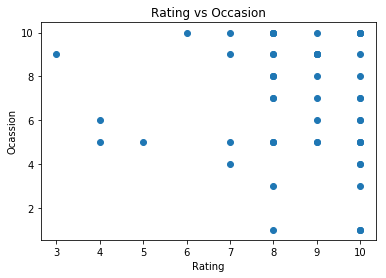

In [43]:
x=df.Rating.values
y=df.Occasion.values
plt.scatter(x,y)
plt.title("Rating vs Occasion")
plt.xlabel("Rating")
plt.ylabel("Ocassion")

Text(0,0.5,'Flavors')

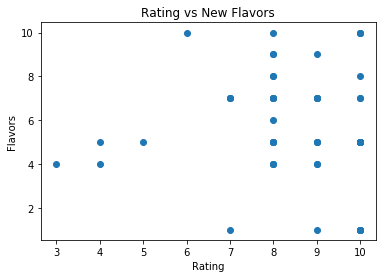

In [44]:
x=df.Rating.values
y=df.New_flavors.values
plt.scatter(x,y)
plt.title("Rating vs New Flavors")
plt.xlabel("Rating")
plt.ylabel("Flavors")

## Prediction

In [45]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
df.Rating.values
df_Y = df.Rating.values
df_X = df.drop(['Rating'],axis=1).values

# Split the data into training/testing sets
df_X_train = df_X[:40,:]
df_X_test = df_X[40:,:]

# Split the targets into training/testing sets
df_y_train = df_Y[:40]
df_y_test = df_Y[40:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(df_X_train, df_y_train)

# Make predictions using the testing set
df_y_pred = regr.predict(df_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(df_y_test, df_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_y_test, df_y_pred))



Coefficients: 
 [-0.02591959  1.14932909  0.74569057  0.18367112  0.63682709 -0.39168443
  0.00752785  3.47957676  0.78174601  0.26501888 -1.49450125  2.80303935
  0.51378201 -3.92669979  0.16720676 -1.98098835  4.07505061 -0.73982956
 -1.14033962  0.96521347 -0.40312109  1.31850372  0.33714824  0.63534395
 -1.44691982  4.07505061 -1.46972004  0.          0.10521282 -1.40503412
 -0.0248841  -1.44691982 -0.40312109  0.1378099   1.08637784 -0.00817752
 -0.05795227  2.3191246  -0.22443717]
Mean squared error: 11.13
Variance score: -4.82


In [46]:
df_y_pred

array([ 9.78596242, 12.98720295,  9.82172577,  7.52853569, 17.69714015,
       10.01922005, 10.44832698,  7.71784984,  4.03905903, 15.80073846,
        7.96495352, -0.19166288, 13.0200239 , 10.88729112,  7.89989271,
        9.00941022,  6.53681518,  8.78432582])